# Node Pruning and Stratified K-Fold Cross-Validation Experiment

## Note: Please refer to the README for instructions on how to acquire the dataset and install dependencies.

## Ensure the dataset is placed in the appropriate directory before running this notebook.

---




## Model Training & Experiment

### Import Necessary Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pickle
import gc
import warnings
import psutil
from tqdm import tqdm
from scipy import stats

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Recall, Precision
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Scikit-learn utilities
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight

# Other necessary libraries
from PIL import Image
import io
import zipfile
import shutil

### Load and Prepare Data

In [3]:
import pandas as pd

# Load training metadata
train_df = pd.read_csv('/content/train-metadata.csv')

# Define image directory
image_dir = '/content/train-image/image'

# Add file paths to the DataFrame
train_df['filepath'] = train_df['isic_id'].apply(lambda x: f"{image_dir}/{x}.jpg")

# Count the number of target (malignant) and benign records before rebalancing
num_benign = len(train_df[train_df['target'] == 0])
num_malignant = len(train_df[train_df['target'] == 1])

print(f"Number of benign samples: {num_benign}")
print(f"Number of malignant samples: {num_malignant}")

# Balance the Dataset with Random Under Sampling (RUS)
# Separate majority and minority classes
benign_df = train_df[train_df['target'] == 0]
malignant_df = train_df[train_df['target'] == 1]

# Perform Random Under Sampling on the majority class
benign_df_under = benign_df.sample(len(malignant_df), random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([benign_df_under, malignant_df])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-3-76b571841d8d>:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/train-metadata.csv')


Number of benign samples: 400666
Number of malignant samples: 393


### Define Model

In [12]:
def build_model():
    # Load the ResNet50V2 model without the top layers
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        units=128,
        activation='relu',
        kernel_regularizer=l2(1e-5)
    )(x)
    x = Dropout(rate=0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Build the complete model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Store the base_model as an attribute of model for easy access
    model.base_model = base_model

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Initial learning rate
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )

    return model

In [11]:
# Build the model
model = build_model()

# Print the model summary
print("Model Summary:")
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Node Pruning within Repeated Stratified K-Fold Cross-Validation

In [14]:
# -------------------
# 1. Setup Logging and Suppress Warnings
# -------------------

logging.basicConfig(
    filename='training.log',
    filemode='a',  # Append mode
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# Suppress specific warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# -------------------
# 2. Initialize Data Structures
# -------------------

# Assuming 'balanced_df' is defined elsewhere in your code
X = balanced_df['filepath']
y = balanced_df['target']

# Parameters
num_folds = 5        # Number of folds per repeat
num_repeats = 5     # Number of repeats
total_splits = num_folds * num_repeats

# Initialize RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=42)

# Initialize a list to collect results
results_list = []

# -------------------
# 3. Define Helper Functions
# -------------------

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 3)  # in GB
    print(f"Current memory usage: {mem:.2f} GB")
    logging.info(f"Current memory usage: {mem:.2f} GB")

def drop_node_in_hidden_layer(model, node_index, original_weights):
    """
    Sets the specified node's weights and bias in the first Dense layer to zero.
    Modifies the model in-place.
    """
    # Access the first Dense layer
    hidden_dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            hidden_dense_layer = layer
            break
    if hidden_dense_layer is None:
        raise ValueError("No Dense layer found in the model.")

    # Save current weights and biases
    weights, biases = hidden_dense_layer.get_weights()
    original_weights['weights'] = weights.copy()
    original_weights['biases'] = biases.copy()

    # Zero out the specified node's weights and bias
    weights[:, node_index] = 0
    biases[node_index] = 0

    # Set the modified weights and biases back to the layer
    hidden_dense_layer.set_weights([weights, biases])

def restore_original_weights(model, original_weights):
    """
    Restores the original weights and biases to the first Dense layer.
    """
    hidden_dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            hidden_dense_layer = layer
            break
    if hidden_dense_layer is not None and original_weights:
        hidden_dense_layer.set_weights([original_weights['weights'], original_weights['biases']])

def prune_nodes(model, nodes_to_prune):
    """
    Prunes the first Dense layer by setting weights of specified nodes to zero.
    Modifies the model in-place.
    """
    # Access the first Dense layer
    hidden_dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            hidden_dense_layer = layer
            break
    if hidden_dense_layer is None:
        raise ValueError("No Dense layer found in the model.")

    # Get weights and biases
    weights, biases = hidden_dense_layer.get_weights()

    # Zero out weights and biases for the specified nodes
    for node_idx in nodes_to_prune:
        weights[:, node_idx] = 0  # Zero out all incoming weights for the node
        biases[node_idx] = 0      # Zero out the node's bias

    # Set the modified weights and biases back to the layer
    hidden_dense_layer.set_weights([weights, biases])

def prune_and_evaluate(model, nodes_to_prune, val_generator, strategy_name, fold):
    """
    Prunes specified nodes, evaluates the model, and restores original weights.
    """
    # Access the first Dense layer
    hidden_dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            hidden_dense_layer = layer
            break

    # Save original weights before pruning
    original_weights = {}
    weights, biases = hidden_dense_layer.get_weights()
    original_weights['weights'] = weights.copy()
    original_weights['biases'] = biases.copy()

    # Prune the nodes
    prune_nodes(model, nodes_to_prune)

    # Evaluate the model
    metrics = model.evaluate(val_generator, verbose=0)
    pruned_loss, pruned_accuracy, pruned_auc, pruned_precision, pruned_recall = metrics

    # Append the results
    results_list.append({
        'Fold': fold,
        'Pruning_Strategy': strategy_name,
        'Accuracy': pruned_accuracy,
        'AUC': pruned_auc,
        'Precision': pruned_precision,
        'Recall': pruned_recall
    })

    # Restore original weights
    restore_original_weights(model, original_weights)
    del original_weights
    gc.collect()

# -------------------
# 4. Training and Pruning Loop
# -------------------

for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y), 1):
    logging.info(f"--- Fold {fold}/{total_splits} ---")
    print(f"Starting Fold {fold}/{total_splits}")
    print_memory_usage()

    try:
        # Split data
        train_data = balanced_df.iloc[train_idx].reset_index(drop=True)
        val_data = balanced_df.iloc[val_idx].reset_index(drop=True)

        # Ensure 'target' column is of string type for data generators
        train_data['target'] = train_data['target'].astype(str)
        val_data['target'] = val_data['target'].astype(str)

        # Data augmentation for training data
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )

        # Data generator for validation data (no augmentation)
        val_datagen = ImageDataGenerator(rescale=1./255)

        # Create data generators
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_data,
            x_col='filepath',
            y_col='target',
            target_size=(224, 224),
            batch_size=16,  # Adjust as needed
            class_mode='binary',
            shuffle=True
        )
        val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_data,
            x_col='filepath',
            y_col='target',
            target_size=(224, 224),
            batch_size=16,
            class_mode='binary',
            shuffle=False
        )

        print("Data generators created successfully.")
        logging.info("Data generators created successfully.")
        print_memory_usage()

        # Build the model
        model = build_model()  # Ensure this function is defined elsewhere
        print("Model built successfully.")
        logging.info("Model built successfully.")
        print_memory_usage()

        # Define callbacks to monitor recall
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            mode='min',
            restore_best_weights=True
        )

        # Define reduce_lr callback
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-7
        )

        # Compile the model with recall as a metric
        model.compile(
            optimizer=Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
        )

        # Train the model (first stage)
        logging.info("Starting initial training...")
        print("Starting initial training...")
        history = model.fit(
            train_generator,
            epochs=10,  # Adjust as needed
            validation_data=val_generator,
            callbacks=[early_stopping],
            verbose=1  # Show progress
        )
        logging.info("Initial training completed.")
        print("Initial training completed.")
        print_memory_usage()

        # Ensure all base model layers are frozen
        for layer in model.base_model.layers:
            layer.trainable = False

        # Ensure only custom layers are trainable
        for layer in model.layers:
            if layer.name in ['global_average_pooling2d', 'dense', 'dropout', 'dense_1']:
                layer.trainable = True

        # Recompile the model with a lower learning rate for fine-tuning
        model.compile(
            optimizer=Adam(learning_rate=1e-6),  # Lower learning rate for fine-tuning
            loss='binary_crossentropy',
            metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
        )

        # Fine-tune the model
        logging.info("Starting fine-tuning...")
        print("Starting fine-tuning...")
        history_fine_tune = model.fit(
            train_generator,
            epochs=5,  # Fewer epochs for fine-tuning
            validation_data=val_generator,
            callbacks=[early_stopping, reduce_lr],
            verbose=1  # Show progress
        )
        logging.info("Fine-tuning completed.")
        print("Fine-tuning completed.")
        print_memory_usage()

        # Evaluate the model
        val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(val_generator, verbose=0)
        logging.info(f'Fold {fold} Validation Accuracy: {val_accuracy:.4f}')
        logging.info(f'Fold {fold} Validation AUC: {val_auc:.4f}')
        logging.info(f'Fold {fold} Validation Precision: {val_precision:.4f}')
        logging.info(f'Fold {fold} Validation Recall: {val_recall:.4f}')
        print(f'Fold {fold} Validation Accuracy: {val_accuracy:.4f}')
        print(f'Fold {fold} Validation AUC: {val_auc:.4f}')
        print(f'Fold {fold} Validation Precision: {val_precision:.4f}')
        print(f'Fold {fold} Validation Recall: {val_recall:.4f}')
        print_memory_usage()

        # Append the baseline performance metrics
        results_list.append({
            'Fold': fold,
            'Pruning_Strategy': 'Baseline',
            'Accuracy': val_accuracy,
            'AUC': val_auc,
            'Precision': val_precision,
            'Recall': val_recall
        })

        # --- Node Pruning Steps ---

        # Identify the first Dense layer
        hidden_dense_layer = None
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                hidden_dense_layer = layer
                break
        if hidden_dense_layer is None:
            logging.error("No Dense layer found in the model. Skipping pruning.")
            print("No Dense layer found in the model. Skipping pruning.")
            continue

        num_nodes = hidden_dense_layer.units
        logging.info(f"Number of nodes in the first Dense layer: {num_nodes}")
        print(f"Number of nodes in the first Dense layer: {num_nodes}")
        print_memory_usage()

        # Dictionaries to store Recall and Delta Recall for each node dropped
        node_recall = {}
        delta_recall = {}

        logging.info("Starting node-dropping analysis...")
        print("Starting node-dropping analysis...")
        # Perform node-dropping analysis
        for node_idx in tqdm(range(num_nodes), desc="Node Pruning"):
            original_weights = {}
            # Drop the node
            drop_node_in_hidden_layer(model, node_idx, original_weights)
            # Evaluate the modified model
            metrics = model.evaluate(val_generator, verbose=0)
            val_loss_mod, val_accuracy_mod, val_auc_mod, val_precision_mod, val_recall_mod = metrics
            node_recall[node_idx] = val_recall_mod
            delta_recall[node_idx] = val_recall_mod - val_recall

            # Restore the original weights
            restore_original_weights(model, original_weights)
            # Clean up
            del original_weights
            gc.collect()

        # Identify nodes to remove based on significant recall improvement
        threshold = 0.01  # Adjust as needed
        nodes_to_remove = [node for node, delta in delta_recall.items() if delta > threshold]
        logging.info(f"Nodes to remove for improved Recall: {nodes_to_remove}")
        print(f"Nodes to remove for improved Recall: {nodes_to_remove}")
        print_memory_usage()

        # Prune and evaluate the model by removing nodes that significantly improved recall
        prune_and_evaluate(model, nodes_to_remove, val_generator, 'Pruned_All', fold)
        print_memory_usage()

        # --- Further Pruning: Top 1, 5, 10, 15 Nodes ---

        # Get sorted nodes based on delta_recall
        sorted_nodes = sorted(delta_recall.items(), key=lambda x: x[1], reverse=True)

        # Define the top N values
        top_N_values = [1, 5, 10, 15]

        for N in top_N_values:
            top_N_nodes = [node for node, delta in sorted_nodes[:N]]
            logging.info(f"Top {N} nodes to prune based on Recall improvement: {top_N_nodes}")
            print(f"Top {N} nodes to prune based on Recall improvement: {top_N_nodes}")
            print_memory_usage()

            # Prune and evaluate
            strategy_name = f'Pruned_Top{N}'
            prune_and_evaluate(model, top_N_nodes, val_generator, strategy_name, fold)
            print_memory_usage()

        # Clean up models and free memory
        del model
        K.clear_session()
        gc.collect()
        logging.info(f"Completed Fold {fold}.\n")
        print(f"Completed Fold {fold}.\n")
        print_memory_usage()

    except Exception as e:
        logging.error(f"Error in Fold {fold}: {e}")
        print(f"Error in Fold {fold}: {e}")
        # Clean up partially created objects
        if 'model' in locals():
            del model
        K.clear_session()
        gc.collect()
        continue  # Proceed to the next fold

# -------------------
# 5. Save Results to Disk
# -------------------

# Create the DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Save the DataFrame to a CSV file
results_df.to_csv('/content/performance_metrics.csv', index=False)
logging.info("All performance metrics have been saved to '/content/performance_metrics.csv'.")
print("All performance metrics have been saved to '/content/performance_metrics.csv'.")

Starting Fold 1/25
Current memory usage: 1.82 GB
Found 628 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 1.82 GB
Model built successfully.
Current memory usage: 1.82 GB
Starting initial training...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 501ms/step - accuracy: 0.6047 - auc: 0.6421 - loss: 0.7225 - precision: 0.6008 - recall: 0.5596 - val_accuracy: 0.6772 - val_auc: 0.7879 - val_loss: 0.5978 - val_precision: 0.6429 - val_recall: 0.7975
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.6793 - auc: 0.7611 - loss: 0.5886 - precision: 0.6695 - recall: 0.7784 - val_accuracy: 0.6646 - val_auc: 0.7991 - val_loss: 0.6386 - val_precision: 0.8421 - val_recall: 0.4051
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.7335 - auc: 0.7771 - loss: 0.5759 - precision: 0.7732 - recall: 0.6730 - val_accuracy: 0.7278 - val_auc: 0.7999 - val_loss: 0.5

Node Pruning: 100%|██████████| 128/128 [01:34<00:00,  1.35it/s]


Nodes to remove for improved Recall: [0, 16, 32, 34, 62, 64, 90, 95, 100, 104, 113, 116, 119, 124]
Current memory usage: 3.62 GB
Current memory usage: 3.63 GB
Top 1 nodes to prune based on Recall improvement: [62]
Current memory usage: 3.63 GB
Current memory usage: 3.63 GB
Top 5 nodes to prune based on Recall improvement: [62, 16, 64, 32, 95]
Current memory usage: 3.63 GB
Current memory usage: 3.63 GB
Top 10 nodes to prune based on Recall improvement: [62, 16, 64, 32, 95, 113, 124, 0, 34, 90]
Current memory usage: 3.63 GB
Current memory usage: 3.63 GB
Top 15 nodes to prune based on Recall improvement: [62, 16, 64, 32, 95, 113, 124, 0, 34, 90, 100, 104, 116, 119, 1]
Current memory usage: 3.63 GB
Current memory usage: 3.63 GB
Completed Fold 1.

Current memory usage: 3.63 GB
Starting Fold 2/25
Current memory usage: 3.63 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current me

Node Pruning: 100%|██████████| 128/128 [01:44<00:00,  1.22it/s]


Nodes to remove for improved Recall: [95, 106, 113]
Current memory usage: 4.32 GB
Current memory usage: 4.32 GB
Top 1 nodes to prune based on Recall improvement: [95]
Current memory usage: 4.32 GB
Current memory usage: 4.32 GB
Top 5 nodes to prune based on Recall improvement: [95, 106, 113, 0, 1]
Current memory usage: 4.32 GB
Current memory usage: 4.32 GB
Top 10 nodes to prune based on Recall improvement: [95, 106, 113, 0, 1, 2, 3, 4, 5, 6]
Current memory usage: 4.32 GB
Current memory usage: 4.32 GB
Top 15 nodes to prune based on Recall improvement: [95, 106, 113, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Current memory usage: 4.32 GB
Current memory usage: 4.32 GB
Completed Fold 2.

Current memory usage: 4.32 GB
Starting Fold 3/25
Current memory usage: 4.32 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 4.32 GB
Model built successfully.
Current memory usag

Node Pruning: 100%|██████████| 128/128 [01:54<00:00,  1.12it/s]


Nodes to remove for improved Recall: [1, 17, 21, 22, 24, 25, 26, 38, 51, 54, 60, 70, 73, 77, 78, 87, 92, 94, 100, 104, 109, 111, 112, 113, 119, 124, 126]
Current memory usage: 4.93 GB
Current memory usage: 4.93 GB
Top 1 nodes to prune based on Recall improvement: [109]
Current memory usage: 4.93 GB
Current memory usage: 4.93 GB
Top 5 nodes to prune based on Recall improvement: [109, 1, 77, 54, 112]
Current memory usage: 4.93 GB
Current memory usage: 4.94 GB
Top 10 nodes to prune based on Recall improvement: [109, 1, 77, 54, 112, 126, 119, 21, 24, 25]
Current memory usage: 4.94 GB
Current memory usage: 4.95 GB
Top 15 nodes to prune based on Recall improvement: [109, 1, 77, 54, 112, 126, 119, 21, 24, 25, 70, 92, 94, 100, 104]
Current memory usage: 4.95 GB
Current memory usage: 4.95 GB
Completed Fold 3.

Current memory usage: 4.95 GB
Starting Fold 4/25
Current memory usage: 4.95 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to

Node Pruning: 100%|██████████| 128/128 [02:04<00:00,  1.03it/s]


Nodes to remove for improved Recall: [10, 30, 51, 61, 62, 63, 68, 74, 81, 85, 87, 96, 97, 118, 124]
Current memory usage: 5.48 GB
Current memory usage: 5.48 GB
Top 1 nodes to prune based on Recall improvement: [30]
Current memory usage: 5.48 GB
Current memory usage: 5.49 GB
Top 5 nodes to prune based on Recall improvement: [30, 10, 51, 61, 62]
Current memory usage: 5.49 GB
Current memory usage: 5.49 GB
Top 10 nodes to prune based on Recall improvement: [30, 10, 51, 61, 62, 63, 68, 74, 81, 85]
Current memory usage: 5.49 GB
Current memory usage: 5.49 GB
Top 15 nodes to prune based on Recall improvement: [30, 10, 51, 61, 62, 63, 68, 74, 81, 85, 87, 96, 97, 118, 124]
Current memory usage: 5.49 GB
Current memory usage: 5.49 GB
Completed Fold 4.

Current memory usage: 5.49 GB
Starting Fold 5/25
Current memory usage: 5.49 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memo

Node Pruning: 100%|██████████| 128/128 [02:18<00:00,  1.08s/it]


Nodes to remove for improved Recall: [0, 2, 3, 11, 21, 32, 35, 52, 65, 70, 81, 85, 97, 99, 100, 107, 110, 112, 113, 117, 118, 124]
Current memory usage: 6.05 GB
Current memory usage: 6.05 GB
Top 1 nodes to prune based on Recall improvement: [32]
Current memory usage: 6.05 GB
Current memory usage: 6.05 GB
Top 5 nodes to prune based on Recall improvement: [32, 100, 3, 70, 117]
Current memory usage: 6.05 GB
Current memory usage: 6.05 GB
Top 10 nodes to prune based on Recall improvement: [32, 100, 3, 70, 117, 35, 99, 0, 2, 11]
Current memory usage: 6.05 GB
Current memory usage: 6.05 GB
Top 15 nodes to prune based on Recall improvement: [32, 100, 3, 70, 117, 35, 99, 0, 2, 11, 21, 52, 65, 81, 85]
Current memory usage: 6.05 GB
Current memory usage: 6.05 GB
Completed Fold 5.

Current memory usage: 6.06 GB
Starting Fold 6/25
Current memory usage: 6.06 GB
Found 628 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Data generators create

Node Pruning: 100%|██████████| 128/128 [02:24<00:00,  1.13s/it]


Nodes to remove for improved Recall: [2, 3, 21, 53, 63, 64, 83, 88, 93]
Current memory usage: 6.63 GB
Current memory usage: 6.64 GB
Top 1 nodes to prune based on Recall improvement: [21]
Current memory usage: 6.64 GB
Current memory usage: 6.64 GB
Top 5 nodes to prune based on Recall improvement: [21, 2, 3, 53, 63]
Current memory usage: 6.64 GB
Current memory usage: 6.64 GB
Top 10 nodes to prune based on Recall improvement: [21, 2, 3, 53, 63, 64, 83, 88, 93, 1]
Current memory usage: 6.64 GB
Current memory usage: 6.65 GB
Top 15 nodes to prune based on Recall improvement: [21, 2, 3, 53, 63, 64, 83, 88, 93, 1, 4, 5, 6, 7, 8]
Current memory usage: 6.65 GB
Current memory usage: 6.65 GB
Completed Fold 6.

Current memory usage: 6.65 GB
Starting Fold 7/25
Current memory usage: 6.65 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 6.65 GB
Model built successfully.

Node Pruning: 100%|██████████| 128/128 [02:34<00:00,  1.21s/it]


Nodes to remove for improved Recall: [49, 55, 56, 69, 72, 76, 95, 106, 109, 118]
Current memory usage: 7.19 GB
Current memory usage: 7.20 GB
Top 1 nodes to prune based on Recall improvement: [69]
Current memory usage: 7.20 GB
Current memory usage: 7.20 GB
Top 5 nodes to prune based on Recall improvement: [69, 118, 49, 55, 56]
Current memory usage: 7.20 GB
Current memory usage: 7.20 GB
Top 10 nodes to prune based on Recall improvement: [69, 118, 49, 55, 56, 72, 76, 95, 106, 109]
Current memory usage: 7.20 GB
Current memory usage: 7.20 GB
Top 15 nodes to prune based on Recall improvement: [69, 118, 49, 55, 56, 72, 76, 95, 106, 109, 0, 1, 2, 4, 5]
Current memory usage: 7.20 GB
Current memory usage: 7.20 GB
Completed Fold 7.

Current memory usage: 7.20 GB
Starting Fold 8/25
Current memory usage: 7.20 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 7.20 GB
M

Node Pruning: 100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Nodes to remove for improved Recall: [0, 22, 27, 63, 69, 86, 87, 92, 94, 119]
Current memory usage: 7.76 GB
Current memory usage: 7.76 GB
Top 1 nodes to prune based on Recall improvement: [92]
Current memory usage: 7.76 GB
Current memory usage: 7.76 GB
Top 5 nodes to prune based on Recall improvement: [92, 63, 94, 0, 22]
Current memory usage: 7.76 GB
Current memory usage: 7.78 GB
Top 10 nodes to prune based on Recall improvement: [92, 63, 94, 0, 22, 27, 69, 86, 87, 119]
Current memory usage: 7.78 GB
Current memory usage: 7.78 GB
Top 15 nodes to prune based on Recall improvement: [92, 63, 94, 0, 22, 27, 69, 86, 87, 119, 1, 3, 4, 5, 6]
Current memory usage: 7.78 GB
Current memory usage: 7.78 GB
Completed Fold 8.

Current memory usage: 7.78 GB
Starting Fold 9/25
Current memory usage: 7.78 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 7.78 GB
Model built 

Node Pruning: 100%|██████████| 128/128 [02:54<00:00,  1.36s/it]


Nodes to remove for improved Recall: [28, 38, 44, 45, 47, 58, 59, 65, 66, 70, 72, 79, 84, 94, 96, 99]
Current memory usage: 8.33 GB
Current memory usage: 8.33 GB
Top 1 nodes to prune based on Recall improvement: [99]
Current memory usage: 8.33 GB
Current memory usage: 8.33 GB
Top 5 nodes to prune based on Recall improvement: [99, 96, 58, 79, 84]
Current memory usage: 8.33 GB
Current memory usage: 8.33 GB
Top 10 nodes to prune based on Recall improvement: [99, 96, 58, 79, 84, 28, 38, 44, 45, 47]
Current memory usage: 8.33 GB
Current memory usage: 8.33 GB
Top 15 nodes to prune based on Recall improvement: [99, 96, 58, 79, 84, 28, 38, 44, 45, 47, 59, 65, 66, 70, 72]
Current memory usage: 8.33 GB
Current memory usage: 8.33 GB
Completed Fold 9.

Current memory usage: 8.33 GB
Starting Fold 10/25
Current memory usage: 8.33 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current mem

Node Pruning: 100%|██████████| 128/128 [03:04<00:00,  1.44s/it]


Nodes to remove for improved Recall: [3, 15, 17, 19, 20, 35, 41, 49, 51, 57, 59, 60, 80, 83, 102, 107, 124]
Current memory usage: 8.89 GB
Current memory usage: 8.89 GB
Top 1 nodes to prune based on Recall improvement: [59]
Current memory usage: 8.89 GB
Current memory usage: 8.90 GB
Top 5 nodes to prune based on Recall improvement: [59, 49, 57, 80, 124]
Current memory usage: 8.90 GB
Current memory usage: 8.90 GB
Top 10 nodes to prune based on Recall improvement: [59, 49, 57, 80, 124, 3, 15, 17, 20, 51]
Current memory usage: 8.90 GB
Current memory usage: 8.90 GB
Top 15 nodes to prune based on Recall improvement: [59, 49, 57, 80, 124, 3, 15, 17, 20, 51, 102, 19, 35, 41, 60]
Current memory usage: 8.90 GB
Current memory usage: 8.90 GB
Completed Fold 10.

Current memory usage: 8.91 GB
Starting Fold 11/25
Current memory usage: 8.91 GB
Found 628 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Data generators created successfully.
Cu

Node Pruning: 100%|██████████| 128/128 [03:14<00:00,  1.52s/it]


Nodes to remove for improved Recall: [18, 19, 23, 79, 84, 89, 104, 109]
Current memory usage: 9.46 GB
Current memory usage: 9.46 GB
Top 1 nodes to prune based on Recall improvement: [23]
Current memory usage: 9.46 GB
Current memory usage: 9.46 GB
Top 5 nodes to prune based on Recall improvement: [23, 89, 18, 19, 79]
Current memory usage: 9.46 GB
Current memory usage: 9.46 GB
Top 10 nodes to prune based on Recall improvement: [23, 89, 18, 19, 79, 84, 104, 109, 0, 1]
Current memory usage: 9.46 GB
Current memory usage: 9.46 GB
Top 15 nodes to prune based on Recall improvement: [23, 89, 18, 19, 79, 84, 104, 109, 0, 1, 2, 3, 5, 6, 7]
Current memory usage: 9.46 GB
Current memory usage: 9.47 GB
Completed Fold 11.

Current memory usage: 9.47 GB
Starting Fold 12/25
Current memory usage: 9.47 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 9.47 GB
Model built suc

Node Pruning: 100%|██████████| 128/128 [03:24<00:00,  1.60s/it]


Nodes to remove for improved Recall: [0, 1, 4, 6, 7, 18, 20, 29, 40, 48, 49, 51, 55, 58, 66, 67, 69, 84, 89, 91, 92, 93, 100, 108, 113, 114, 116]
Current memory usage: 10.05 GB
Current memory usage: 10.05 GB
Top 1 nodes to prune based on Recall improvement: [114]
Current memory usage: 10.05 GB
Current memory usage: 10.05 GB
Top 5 nodes to prune based on Recall improvement: [114, 40, 4, 6, 20]
Current memory usage: 10.05 GB
Current memory usage: 10.05 GB
Top 10 nodes to prune based on Recall improvement: [114, 40, 4, 6, 20, 48, 91, 0, 1, 7]
Current memory usage: 10.05 GB
Current memory usage: 10.06 GB
Top 15 nodes to prune based on Recall improvement: [114, 40, 4, 6, 20, 48, 91, 0, 1, 7, 18, 29, 49, 51, 55]
Current memory usage: 10.06 GB
Current memory usage: 10.06 GB
Completed Fold 12.

Current memory usage: 10.06 GB
Starting Fold 13/25
Current memory usage: 10.06 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.


Node Pruning: 100%|██████████| 128/128 [03:34<00:00,  1.67s/it]


Nodes to remove for improved Recall: [16, 54, 65, 95]
Current memory usage: 10.60 GB
Current memory usage: 10.61 GB
Top 1 nodes to prune based on Recall improvement: [16]
Current memory usage: 10.61 GB
Current memory usage: 10.61 GB
Top 5 nodes to prune based on Recall improvement: [16, 54, 65, 95, 1]
Current memory usage: 10.61 GB
Current memory usage: 10.61 GB
Top 10 nodes to prune based on Recall improvement: [16, 54, 65, 95, 1, 3, 5, 6, 7, 8]
Current memory usage: 10.61 GB
Current memory usage: 10.61 GB
Top 15 nodes to prune based on Recall improvement: [16, 54, 65, 95, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Current memory usage: 10.61 GB
Current memory usage: 10.61 GB
Completed Fold 13.

Current memory usage: 10.61 GB
Starting Fold 14/25
Current memory usage: 10.61 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 10.61 GB
Model built successfully.
Cur

Node Pruning: 100%|██████████| 128/128 [03:43<00:00,  1.74s/it]


Nodes to remove for improved Recall: [0, 13, 14, 28, 32, 34, 60, 93, 94, 103, 105, 123]
Current memory usage: 11.17 GB
Current memory usage: 11.18 GB
Top 1 nodes to prune based on Recall improvement: [13]
Current memory usage: 11.18 GB
Current memory usage: 11.18 GB
Top 5 nodes to prune based on Recall improvement: [13, 32, 103, 0, 34]
Current memory usage: 11.18 GB
Current memory usage: 11.18 GB
Top 10 nodes to prune based on Recall improvement: [13, 32, 103, 0, 34, 105, 123, 14, 28, 60]
Current memory usage: 11.18 GB
Current memory usage: 11.18 GB
Top 15 nodes to prune based on Recall improvement: [13, 32, 103, 0, 34, 105, 123, 14, 28, 60, 93, 94, 1, 2, 3]
Current memory usage: 11.18 GB
Current memory usage: 11.18 GB
Completed Fold 14.

Current memory usage: 11.18 GB
Starting Fold 15/25
Current memory usage: 11.18 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current mem

Node Pruning: 100%|██████████| 128/128 [03:53<00:00,  1.82s/it]


Nodes to remove for improved Recall: [18, 31, 36, 37, 49, 52, 55, 57, 75, 93, 105, 110, 112, 119, 121, 122, 123, 124, 125]
Current memory usage: 11.75 GB
Current memory usage: 11.75 GB
Top 1 nodes to prune based on Recall improvement: [18]
Current memory usage: 11.75 GB
Current memory usage: 11.75 GB
Top 5 nodes to prune based on Recall improvement: [18, 49, 55, 122, 125]
Current memory usage: 11.75 GB
Current memory usage: 11.75 GB
Top 10 nodes to prune based on Recall improvement: [18, 49, 55, 122, 125, 37, 52, 75, 93, 112]
Current memory usage: 11.75 GB
Current memory usage: 11.77 GB
Top 15 nodes to prune based on Recall improvement: [18, 49, 55, 122, 125, 37, 52, 75, 93, 112, 121, 123, 124, 31, 36]
Current memory usage: 11.77 GB
Current memory usage: 11.77 GB
Completed Fold 15.

Current memory usage: 11.77 GB
Starting Fold 16/25
Current memory usage: 11.77 GB
Found 628 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Data

Node Pruning: 100%|██████████| 128/128 [04:03<00:00,  1.90s/it]


Nodes to remove for improved Recall: [4, 11, 31, 34, 38, 47, 50, 58, 61, 68, 84, 90, 94, 97, 102, 125]
Current memory usage: 12.30 GB
Current memory usage: 12.31 GB
Top 1 nodes to prune based on Recall improvement: [58]
Current memory usage: 12.31 GB
Current memory usage: 12.31 GB
Top 5 nodes to prune based on Recall improvement: [58, 94, 61, 68, 4]
Current memory usage: 12.31 GB
Current memory usage: 12.31 GB
Top 10 nodes to prune based on Recall improvement: [58, 94, 61, 68, 4, 11, 31, 34, 38, 47]
Current memory usage: 12.31 GB
Current memory usage: 12.31 GB
Top 15 nodes to prune based on Recall improvement: [58, 94, 61, 68, 4, 11, 31, 34, 38, 47, 50, 84, 90, 97, 102]
Current memory usage: 12.31 GB
Current memory usage: 12.31 GB
Completed Fold 16.

Current memory usage: 12.31 GB
Starting Fold 17/25
Current memory usage: 12.31 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.

Node Pruning: 100%|██████████| 128/128 [04:12<00:00,  1.97s/it]


Nodes to remove for improved Recall: [11, 27, 39, 49, 91, 118, 125, 126, 127]
Current memory usage: 12.95 GB
Current memory usage: 12.96 GB
Top 1 nodes to prune based on Recall improvement: [11]
Current memory usage: 12.96 GB
Current memory usage: 12.96 GB
Top 5 nodes to prune based on Recall improvement: [11, 27, 39, 49, 91]
Current memory usage: 12.96 GB
Current memory usage: 12.96 GB
Top 10 nodes to prune based on Recall improvement: [11, 27, 39, 49, 91, 118, 125, 126, 127, 0]
Current memory usage: 12.96 GB
Current memory usage: 12.96 GB
Top 15 nodes to prune based on Recall improvement: [11, 27, 39, 49, 91, 118, 125, 126, 127, 0, 2, 4, 5, 6, 8]
Current memory usage: 12.96 GB
Current memory usage: 12.96 GB
Completed Fold 17.

Current memory usage: 12.96 GB
Starting Fold 18/25
Current memory usage: 12.96 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage:

Node Pruning: 100%|██████████| 128/128 [04:21<00:00,  2.04s/it]


Nodes to remove for improved Recall: [2, 4, 8, 10, 19, 22, 23, 26, 34, 41, 61, 63, 85, 92, 96, 100, 101, 104, 113, 114]
Current memory usage: 13.51 GB
Current memory usage: 13.52 GB
Top 1 nodes to prune based on Recall improvement: [22]
Current memory usage: 13.52 GB
Current memory usage: 13.52 GB
Top 5 nodes to prune based on Recall improvement: [22, 114, 10, 34, 61]
Current memory usage: 13.52 GB
Current memory usage: 13.52 GB
Top 10 nodes to prune based on Recall improvement: [22, 114, 10, 34, 61, 63, 92, 101, 104, 113]
Current memory usage: 13.52 GB
Current memory usage: 13.52 GB
Top 15 nodes to prune based on Recall improvement: [22, 114, 10, 34, 61, 63, 92, 101, 104, 113, 2, 4, 8, 19, 23]
Current memory usage: 13.52 GB
Current memory usage: 13.52 GB
Completed Fold 18.

Current memory usage: 13.52 GB
Starting Fold 19/25
Current memory usage: 13.52 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generat

Node Pruning: 100%|██████████| 128/128 [04:31<00:00,  2.12s/it]


Nodes to remove for improved Recall: [4, 10, 47, 61, 66, 70, 85, 98]
Current memory usage: 14.08 GB
Current memory usage: 14.09 GB
Top 1 nodes to prune based on Recall improvement: [4]
Current memory usage: 14.09 GB
Current memory usage: 14.09 GB
Top 5 nodes to prune based on Recall improvement: [4, 47, 10, 61, 66]
Current memory usage: 14.09 GB
Current memory usage: 14.09 GB
Top 10 nodes to prune based on Recall improvement: [4, 47, 10, 61, 66, 70, 85, 98, 0, 1]
Current memory usage: 14.09 GB
Current memory usage: 14.10 GB
Top 15 nodes to prune based on Recall improvement: [4, 47, 10, 61, 66, 70, 85, 98, 0, 1, 2, 5, 6, 7, 11]
Current memory usage: 14.10 GB
Current memory usage: 14.10 GB
Completed Fold 19.

Current memory usage: 14.10 GB
Starting Fold 20/25
Current memory usage: 14.10 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 14.10 GB
Model built 

Node Pruning: 100%|██████████| 128/128 [04:40<00:00,  2.19s/it]


Nodes to remove for improved Recall: [0, 2, 16, 21, 35, 38, 51, 53, 57, 79, 81, 113, 118]
Current memory usage: 14.66 GB
Current memory usage: 14.67 GB
Top 1 nodes to prune based on Recall improvement: [79]
Current memory usage: 14.67 GB
Current memory usage: 14.67 GB
Top 5 nodes to prune based on Recall improvement: [79, 35, 38, 51, 118]
Current memory usage: 14.67 GB
Current memory usage: 14.67 GB
Top 10 nodes to prune based on Recall improvement: [79, 35, 38, 51, 118, 0, 2, 16, 21, 53]
Current memory usage: 14.67 GB
Current memory usage: 14.67 GB
Top 15 nodes to prune based on Recall improvement: [79, 35, 38, 51, 118, 0, 2, 16, 21, 53, 57, 81, 113, 1, 3]
Current memory usage: 14.67 GB
Current memory usage: 14.67 GB
Completed Fold 20.

Current memory usage: 14.67 GB
Starting Fold 21/25
Current memory usage: 14.67 GB
Found 628 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memo

Node Pruning: 100%|██████████| 128/128 [04:50<00:00,  2.27s/it]


Nodes to remove for improved Recall: [9, 20, 25, 31, 42, 43, 44, 51, 53, 65, 79, 84, 85, 92, 114, 115, 116, 121]
Current memory usage: 15.26 GB
Current memory usage: 15.22 GB
Top 1 nodes to prune based on Recall improvement: [84]
Current memory usage: 15.22 GB
Current memory usage: 15.23 GB
Top 5 nodes to prune based on Recall improvement: [84, 31, 43, 53, 92]
Current memory usage: 15.23 GB
Current memory usage: 15.23 GB
Top 10 nodes to prune based on Recall improvement: [84, 31, 43, 53, 92, 9, 20, 25, 42, 44]
Current memory usage: 15.23 GB
Current memory usage: 15.23 GB
Top 15 nodes to prune based on Recall improvement: [84, 31, 43, 53, 92, 9, 20, 25, 42, 44, 51, 65, 79, 85, 114]
Current memory usage: 15.23 GB
Current memory usage: 15.23 GB
Completed Fold 21.

Current memory usage: 15.23 GB
Starting Fold 22/25
Current memory usage: 15.23 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created su

Node Pruning: 100%|██████████| 128/128 [05:04<00:00,  2.38s/it]


Nodes to remove for improved Recall: [12, 31, 40, 48, 58, 60, 74, 77, 84, 106, 107, 116]
Current memory usage: 15.85 GB
Current memory usage: 15.80 GB
Top 1 nodes to prune based on Recall improvement: [107]
Current memory usage: 15.80 GB
Current memory usage: 15.80 GB
Top 5 nodes to prune based on Recall improvement: [107, 40, 48, 60, 106]
Current memory usage: 15.80 GB
Current memory usage: 15.81 GB
Top 10 nodes to prune based on Recall improvement: [107, 40, 48, 60, 106, 116, 12, 31, 58, 74]
Current memory usage: 15.81 GB
Current memory usage: 15.81 GB
Top 15 nodes to prune based on Recall improvement: [107, 40, 48, 60, 106, 116, 12, 31, 58, 74, 77, 84, 0, 1, 2]
Current memory usage: 15.81 GB
Current memory usage: 15.81 GB
Completed Fold 22.

Current memory usage: 15.81 GB
Starting Fold 23/25
Current memory usage: 15.81 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Curre

Node Pruning: 100%|██████████| 128/128 [05:16<00:00,  2.47s/it]


Nodes to remove for improved Recall: [4, 16, 43, 71, 84]
Current memory usage: 16.41 GB
Current memory usage: 16.41 GB
Top 1 nodes to prune based on Recall improvement: [16]
Current memory usage: 16.41 GB
Current memory usage: 16.37 GB
Top 5 nodes to prune based on Recall improvement: [16, 71, 4, 43, 84]
Current memory usage: 16.37 GB
Current memory usage: 16.38 GB
Top 10 nodes to prune based on Recall improvement: [16, 71, 4, 43, 84, 0, 1, 2, 3, 5]
Current memory usage: 16.38 GB
Current memory usage: 16.39 GB
Top 15 nodes to prune based on Recall improvement: [16, 71, 4, 43, 84, 0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
Current memory usage: 16.39 GB
Current memory usage: 16.39 GB
Completed Fold 23.

Current memory usage: 16.39 GB
Starting Fold 24/25
Current memory usage: 16.39 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 16.39 GB
Model built successfully.
Cur

Node Pruning: 100%|██████████| 128/128 [05:25<00:00,  2.54s/it]


Nodes to remove for improved Recall: [20, 27, 31, 58, 85, 109, 126]
Current memory usage: 16.99 GB
Current memory usage: 16.99 GB
Top 1 nodes to prune based on Recall improvement: [20]
Current memory usage: 16.99 GB
Current memory usage: 16.90 GB
Top 5 nodes to prune based on Recall improvement: [20, 109, 27, 31, 126]
Current memory usage: 16.90 GB
Current memory usage: 16.93 GB
Top 10 nodes to prune based on Recall improvement: [20, 109, 27, 31, 126, 58, 85, 0, 1, 2]
Current memory usage: 16.93 GB
Current memory usage: 16.94 GB
Top 15 nodes to prune based on Recall improvement: [20, 109, 27, 31, 126, 58, 85, 0, 1, 2, 3, 4, 5, 6, 7]
Current memory usage: 16.94 GB
Current memory usage: 16.94 GB
Completed Fold 24.

Current memory usage: 16.94 GB
Starting Fold 25/25
Current memory usage: 16.94 GB
Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Data generators created successfully.
Current memory usage: 16.95 GB
Model 

Node Pruning: 100%|██████████| 128/128 [05:35<00:00,  2.62s/it]


Nodes to remove for improved Recall: [2, 6, 26, 75, 82, 83, 86, 88, 93, 98, 100, 109, 116, 117, 124]
Current memory usage: 17.55 GB
Current memory usage: 17.55 GB
Top 1 nodes to prune based on Recall improvement: [6]
Current memory usage: 17.55 GB
Current memory usage: 17.55 GB
Top 5 nodes to prune based on Recall improvement: [6, 88, 2, 26, 75]
Current memory usage: 17.55 GB
Current memory usage: 17.50 GB
Top 10 nodes to prune based on Recall improvement: [6, 88, 2, 26, 75, 82, 83, 86, 93, 98]
Current memory usage: 17.50 GB
Current memory usage: 17.51 GB
Top 15 nodes to prune based on Recall improvement: [6, 88, 2, 26, 75, 82, 83, 86, 93, 98, 100, 109, 116, 117, 124]
Current memory usage: 17.51 GB
Current memory usage: 17.51 GB
Completed Fold 25.

Current memory usage: 17.51 GB
All performance metrics have been saved to '/content/performance_metrics.csv'.


## Statistical Testing & Analysis of Results

### Aggregating Results for Statistical Testing

In [18]:
import numpy as np

# List of pruning strategies including Baseline
pruning_strategies = ['Baseline', 'Pruned_All', 'Pruned_Top1', 'Pruned_Top5', 'Pruned_Top10', 'Pruned_Top15']

# Initialize a DataFrame to store aggregated metrics
aggregated_metrics = results_df.groupby('Pruning_Strategy').agg({
    'Accuracy': ['mean', 'std'],
    'AUC': ['mean', 'std'],
    'Precision': ['mean', 'std'],
    'Recall': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns
aggregated_metrics.columns = ['Pruning_Strategy',
                              'Accuracy_Mean', 'Accuracy_STD',
                              'AUC_Mean', 'AUC_STD',
                              'Precision_Mean', 'Precision_STD',
                              'Recall_Mean', 'Recall_STD']

# Display the aggregated metrics
print('\n=== Aggregated Performance Metrics ===')
print(aggregated_metrics)


=== Aggregated Performance Metrics ===
  Pruning_Strategy  Accuracy_Mean  Accuracy_STD  AUC_Mean   AUC_STD  \
0         Baseline       0.732333      0.028750  0.813106  0.028185   
1       Pruned_All       0.623697      0.084680  0.802808  0.029644   
2      Pruned_Top1       0.735896      0.029623  0.811904  0.028516   
3     Pruned_Top10       0.682467      0.045704  0.810717  0.029216   
4     Pruned_Top15       0.637707      0.075146  0.806082  0.028215   
5      Pruned_Top5       0.719102      0.036152  0.811323  0.028530   

   Precision_Mean  Precision_STD  Recall_Mean  Recall_STD  
0        0.779770       0.048428     0.654047    0.058530  
1        0.595009       0.084355     0.916741    0.095286  
2        0.759122       0.046238     0.697838    0.055665  
3        0.639662       0.062164     0.882116    0.080172  
4        0.603628       0.077526     0.910114    0.088356  
5        0.695792       0.052861     0.798708    0.075393  


### Node Pruning Analysis

Baseline has 25 observations.
Pruned_All has 25 observations.
Pruned_Top1 has 25 observations.
Pruned_Top5 has 25 observations.
Pruned_Top10 has 25 observations.
Pruned_Top15 has 25 observations.

Adjusted alpha after Bonferroni correction: 0.010000

--- Pruned All ---
Shapiro-Wilk Test: statistic = 0.9684, p-value = 0.6050
Paired t-test: statistic = 11.9406, p-value = 0.000000
Result: Statistically significant difference.
Cohen's d: 2.3881

--- Pruned Top1 ---
Shapiro-Wilk Test: statistic = 0.9164, p-value = 0.0424
Paired t-test: statistic = 11.2414, p-value = 0.000000
Result: Statistically significant difference.
Cohen's d: 2.2483

--- Pruned Top5 ---
Shapiro-Wilk Test: statistic = 0.9717, p-value = 0.6892
Paired t-test: statistic = 11.1339, p-value = 0.000000
Result: Statistically significant difference.
Cohen's d: 2.2268

--- Pruned Top10 ---
Shapiro-Wilk Test: statistic = 0.9505, p-value = 0.2567
Paired t-test: statistic = 12.4798, p-value = 0.000000
Result: Statistically signific

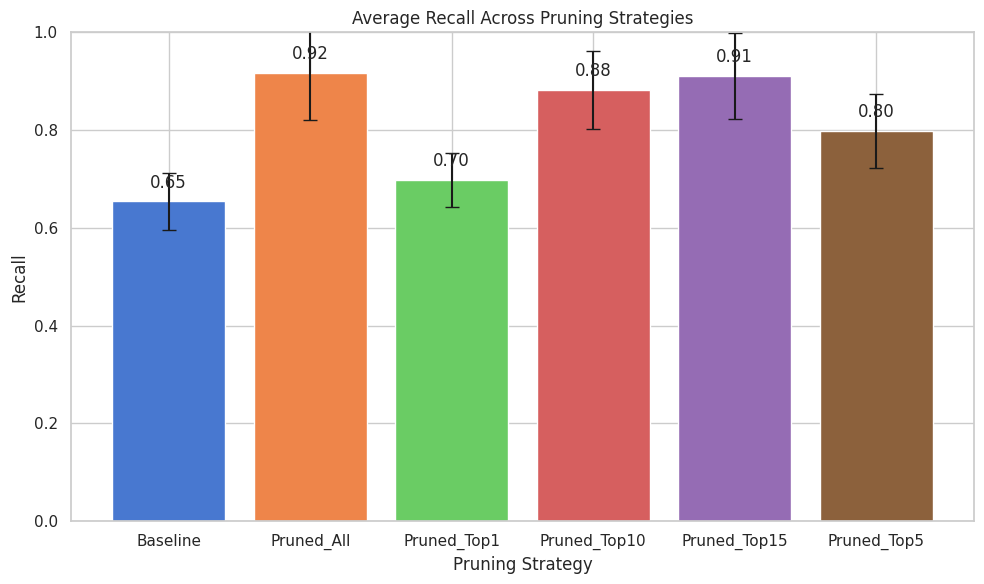

<ipython-input-19-6d998a092ce3>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pruning_Strategy', y='Recall', data=results_df, palette="Set3")


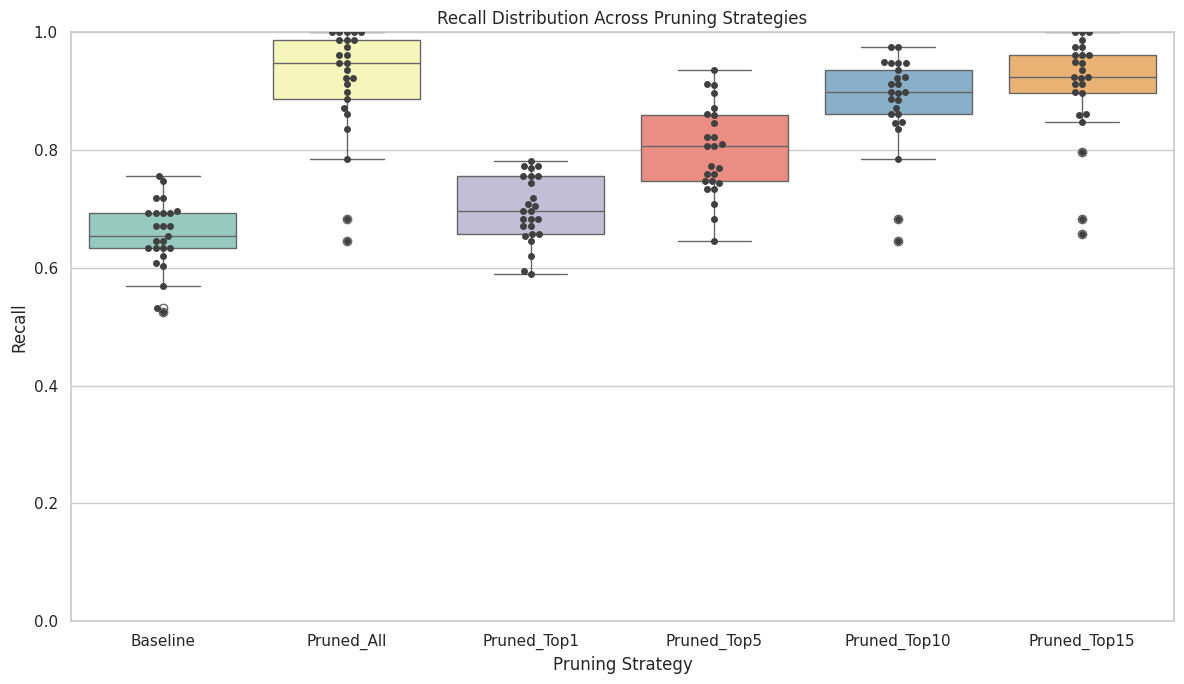

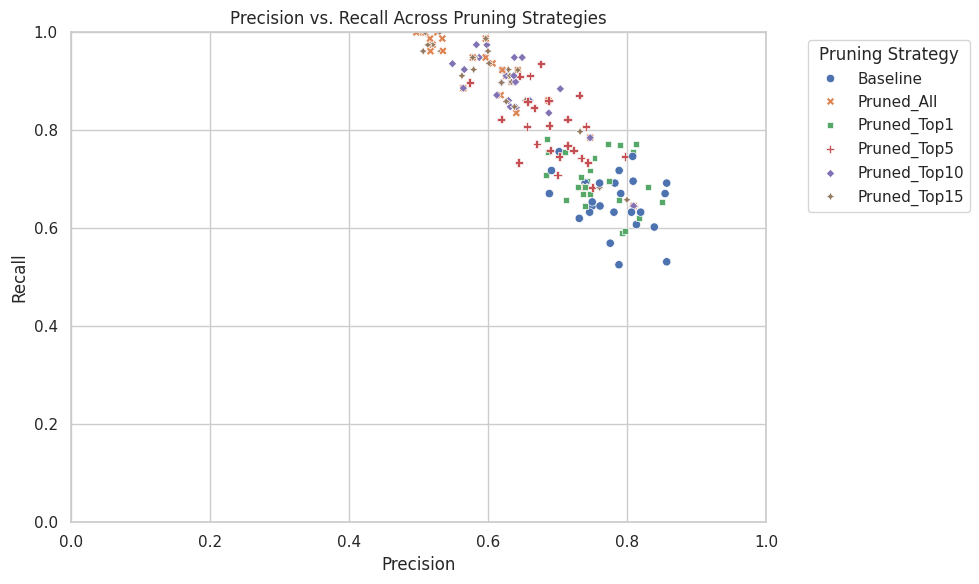

Bar chart saved to 'bar_chart_recall.png'.


In [19]:
# -------------------
# 1. Verify Observations per Pruning Strategy
# -------------------

#List of pruning strategies
pruning_strategies = ['Baseline', 'Pruned_All', 'Pruned_Top1', 'Pruned_Top5', 'Pruned_Top10', 'Pruned_Top15']

# Verify that each pruning strategy has the same number of observations
for strategy in pruning_strategies:
    count = results_df[results_df['Pruning_Strategy'] == strategy].shape[0]
    print(f"{strategy} has {count} observations.")

# -------------------
# 2. Statistical Tests and Effect Size Calculation
# -------------------

# Define a function to perform statistical tests and calculate Cohen's d
def perform_statistical_analysis(baseline, pruned, strategy_name, alpha=0.05):
    """
    Performs Shapiro-Wilk test for normality, followed by Paired t-test or Wilcoxon test.
    Calculates Cohen's d.
    Prints the results and interpretation.
    """
    differences = pruned - baseline
    shapiro_stat, shapiro_p = stats.shapiro(differences)
    print(f"\n--- {strategy_name} ---")
    print(f"Shapiro-Wilk Test: statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

    if shapiro_p > alpha:
        # Data is normally distributed; use Paired t-test
        t_stat, p_value = stats.ttest_rel(pruned, baseline)
        test_used = "Paired t-test"
    else:
        # Data is not normally distributed; use Wilcoxon Signed-Rank Test
        t_stat, p_value = stats.wilcoxon(pruned, baseline)
        test_used = "Wilcoxon Signed-Rank Test"

    print(f"{test_used}: statistic = {t_stat:.4f}, p-value = {p_value:.6f}")

    # Interpretation
    if p_value < alpha:
        print("Result: Statistically significant difference.")
    else:
        print("Result: No statistically significant difference.")

    # Calculate Cohen's d for effect size
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    cohen_d = mean_diff / std_diff if std_diff != 0 else np.inf
    print(f"Cohen's d: {cohen_d:.4f}")

# Extract baseline Recall scores
baseline_recall = results_df[results_df['Pruning_Strategy'] == 'Baseline']['Recall'].values

# List of pruning strategies excluding Baseline
pruning_strategies_to_test = ['Pruned_All', 'Pruned_Top1', 'Pruned_Top5', 'Pruned_Top10', 'Pruned_Top15']

# Number of tests (number of strategies * number of metrics)
num_strategies = len(pruning_strategies_to_test)
num_metrics = 1  # We are testing Recall; adjust if testing more metrics
num_tests = num_strategies * num_metrics

# Adjusted alpha using Bonferroni correction
alpha_bonferroni = 0.05 / num_tests
print(f"\nAdjusted alpha after Bonferroni correction: {alpha_bonferroni:.6f}")

# Perform statistical analysis for each pruning strategy
for strategy in pruning_strategies_to_test:
    # Extract pruned Recall scores
    pruned_recall = results_df[results_df['Pruning_Strategy'] == strategy]['Recall'].values

    # Perform statistical test with adjusted alpha
    perform_statistical_analysis(baseline_recall, pruned_recall, strategy.replace('_', ' ').title(), alpha=alpha_bonferroni)

# -------------------
# 3. Visualization
# -------------------

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# --- Bar Plot of Average Recall with Error Bars ---

# Prepare data
x = np.arange(len(aggregated_metrics))
y = aggregated_metrics['Recall_Mean']
yerr = aggregated_metrics['Recall_STD']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, yerr=yerr, capsize=5, color=sns.color_palette("muted"))

# Set x-ticks labels
plt.xticks(x, aggregated_metrics['Pruning_Strategy'])

# Add titles and labels
plt.title('Average Recall Across Pruning Strategies')
plt.ylabel('Recall')
plt.xlabel('Pruning Strategy')

# Adjust y-axis limits if necessary
plt.ylim(0, 1)

# Annotate the bars with the mean values
for index, (mean, std) in enumerate(zip(y, yerr)):
    plt.text(index, mean + 0.02, f"{mean:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# --- Box Plot of Recall Distribution ---

plt.figure(figsize=(12, 7))
sns.boxplot(x='Pruning_Strategy', y='Recall', data=results_df, palette="Set3")
sns.swarmplot(x='Pruning_Strategy', y='Recall', data=results_df, color=".25")

# Add titles and labels
plt.title('Recall Distribution Across Pruning Strategies')
plt.ylabel('Recall')
plt.xlabel('Pruning Strategy')

# Adjust y-axis limits if necessary
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# --- Scatter Plot of Precision vs Recall ---

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Precision', y='Recall', hue='Pruning_Strategy',
                style='Pruning_Strategy', data=results_df, palette="deep")

# Add titles and labels
plt.title('Precision vs. Recall Across Pruning Strategies')
plt.xlabel('Precision')
plt.ylabel('Recall')

# Adjust axis limits if necessary
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(title='Pruning Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Save Bar Chart as Image ---

# Prepare data
x = np.arange(len(aggregated_metrics))
y = aggregated_metrics['Recall_Mean']
yerr = aggregated_metrics['Recall_STD']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, yerr=yerr, capsize=5, color='skyblue', edgecolor='black')

# Set x-ticks labels
plt.xticks(x, aggregated_metrics['Pruning_Strategy'])

# Add titles and labels
plt.title('Average Recall Across Pruning Strategies')
plt.ylabel('Recall')
plt.xlabel('Pruning Strategy')

# Adjust y-axis limits if necessary
plt.ylim(0, 1)

# Annotate the bars with the mean values
for index, (mean, std) in enumerate(zip(y, yerr)):
    plt.text(index, mean + 0.02, f"{mean:.2f}", ha='center', va='bottom')

plt.tight_layout()
# Save the figure
plt.savefig('bar_chart_recall.png')
plt.close()
print("Bar chart saved to 'bar_chart_recall.png'.")